# 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from scipy.stats import kendalltau
from sklearn.feature_selection import f_classif
import re
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

## 

In [2]:
df_client = pd.read_csv("../data/raw/df_client.csv")

In [3]:
# X_train, X_test, y_train, y_test = train_test_split(df_client.drop(columns=["risk_rating", "Self_exclude_flag"]), 
#                                                     df_client[["risk_rating", "Self_exclude_flag"]],
#                                                     test_size=0.2, random_state=0)

## Missing data handling

In [4]:
# first count number of rows with all variable missing
print(df_client.iloc[:,6:].isna().all(axis=1).sum())

# remove rows with all variable data missing since it's a small portion and 
# these rows are definitely useless
df_client = df_client.iloc[(~df_client.iloc[:,6:].isna().all(axis=1)).tolist(),:]

212


In [5]:
# next, try different methods of missing data handling

# Since the data contains some extreme outliers (such as 260 million where the mean is about 600k),
# extreme outliers (more than 3 sd's away from the mean) are removed before imputation, so that the
# statistics of the data are not affected greatly by the outliers.
mean_variables = np.asarray(df_client.iloc[:,6:].mean())
sd_variables = np.asarray(df_client.iloc[:,6:].std())
df_client = df_client.iloc[(~(np.abs(df_client.iloc[:,6:] - mean_variables) > sd_variables * 3).any(axis=1)).to_list(),:]

# 1. drop columns with more than 20% missing data, and then drop any rows with missing data
df_1 = df_client.loc[:, df_client.isna().mean() < 0.2].dropna().copy()

# 2. drop columns with more than 40% missing data, and then drop any rows with missing data
df_2 = df_client.loc[:, df_client.isna().mean() < 0.4].dropna().copy()

# 3. impute the missing data with the mean

# impute with mean
df_3 = df_client.copy()
simple_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
simple_imp.fit(df_3.iloc[:,6:])
SimpleImputer()
df_3.iloc[:,6:] = simple_imp.transform(df_3.iloc[:,6:])

# 4. impute the missing data using regression
# Similarly, to have the regression work well, the filtered original data was used to run the regression
df_4 = df_client.copy()
reg_imp = IterativeImputer(max_iter=20, random_state=0, verbose=2)
reg_imp.fit(df_4.iloc[:,6:])
IterativeImputer(random_state=0)
df_4.iloc[:,6:] = reg_imp.transform(df_4.iloc[:,6:])

[IterativeImputer] Completing matrix with shape (26276, 118)
[IterativeImputer] Ending imputation round 1/20, elapsed time 45.94
[IterativeImputer] Change: 4379667249.152146, scaled tolerance: 1050627.662 
[IterativeImputer] Ending imputation round 2/20, elapsed time 91.12
[IterativeImputer] Change: 1133247648.5517273, scaled tolerance: 1050627.662 
[IterativeImputer] Ending imputation round 3/20, elapsed time 137.40
[IterativeImputer] Change: 1009489453.7619381, scaled tolerance: 1050627.662 
[IterativeImputer] Ending imputation round 4/20, elapsed time 187.22
[IterativeImputer] Change: 450892012.8478889, scaled tolerance: 1050627.662 
[IterativeImputer] Ending imputation round 5/20, elapsed time 236.81
[IterativeImputer] Change: 132479960.22172342, scaled tolerance: 1050627.662 
[IterativeImputer] Ending imputation round 6/20, elapsed time 285.90
[IterativeImputer] Change: 92913614.25538512, scaled tolerance: 1050627.662 
[IterativeImputer] Ending imputation round 7/20, elapsed time 

/Users/qiaoxuan/miniforge3/envs/automl/lib/python3.9/site-packages/sklearn/impute/_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[IterativeImputer] Ending imputation round 1/20, elapsed time 0.85
[IterativeImputer] Ending imputation round 2/20, elapsed time 1.57
[IterativeImputer] Ending imputation round 3/20, elapsed time 2.23
[IterativeImputer] Ending imputation round 4/20, elapsed time 2.90
[IterativeImputer] Ending imputation round 5/20, elapsed time 3.61
[IterativeImputer] Ending imputation round 6/20, elapsed time 4.35
[IterativeImputer] Ending imputation round 7/20, elapsed time 5.21
[IterativeImputer] Ending imputation round 8/20, elapsed time 6.14
[IterativeImputer] Ending imputation round 9/20, elapsed time 6.97
[IterativeImputer] Ending imputation round 10/20, elapsed time 7.80
[IterativeImputer] Ending imputation round 11/20, elapsed time 8.44
[IterativeImputer] Ending imputation round 12/20, elapsed time 9.08
[IterativeImputer] Ending imputation round 13/20, elapsed time 9.80
[IterativeImputer] Ending imputation round 14/20, elapsed time 10.47
[IterativeImputer] Ending imputation round 15/20, elapse

## Feature selection based on **inter-feature** correlation


In [6]:
# look at the correlation within each variable after handling missing data
def plot_within_var_corr(df):
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    fig, axs = plt.subplots(5, 6, figsize = (24,21))

    for i in range(30):
        cols = list(filter(lambda x: x.startswith(f'Variable_{i+1}_'), df.columns))
        axs[i//6][i%6].set_title(f"Variable_{i+1}")
        sns.heatmap(data=df[cols].corr(), ax=axs[i//6][i%6], cmap=cmap, annot=True, vmin=-1, vmax=1,
                    xticklabels=False, yticklabels=False, square=True, cbar=False)

    fig.colorbar(axs[1][0].get_children()[0], ax=axs.ravel().tolist(), aspect=100, 
                 location="top", orientation="horizontal", anchor=(0.5, 1.5))
    fig.suptitle("Correlation between years (Y0, Y1, Y2, Y3) of each variable", fontsize=40)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

    plt.show()

/var/folders/cd/jmqvxpzd3fl3bkwgtg4gwnfc0000gn/T/ipykernel_59396/2628568303.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


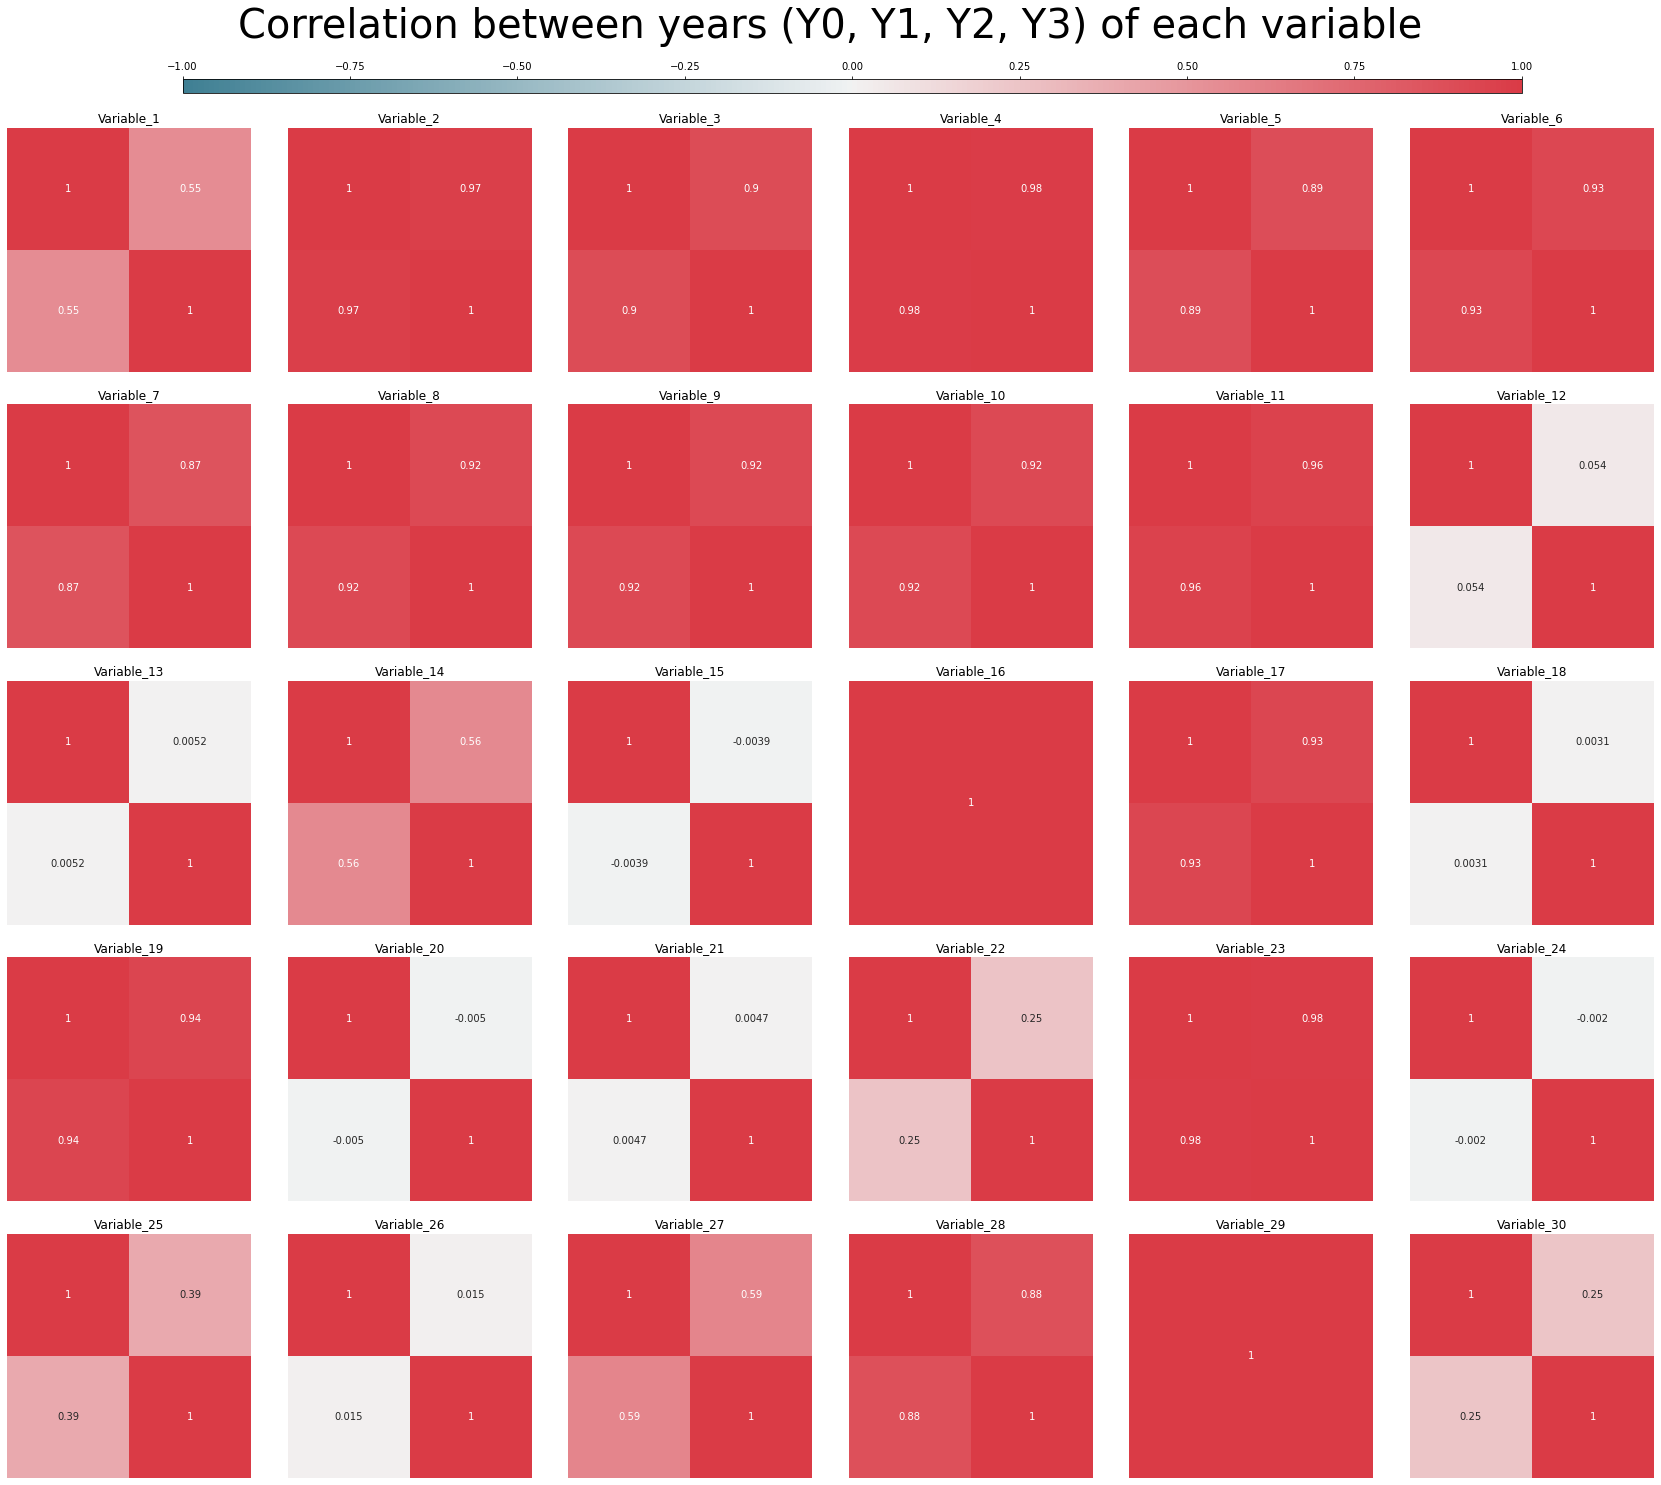

In [7]:
plot_within_var_corr(df_1)

/var/folders/cd/jmqvxpzd3fl3bkwgtg4gwnfc0000gn/T/ipykernel_59396/2628568303.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


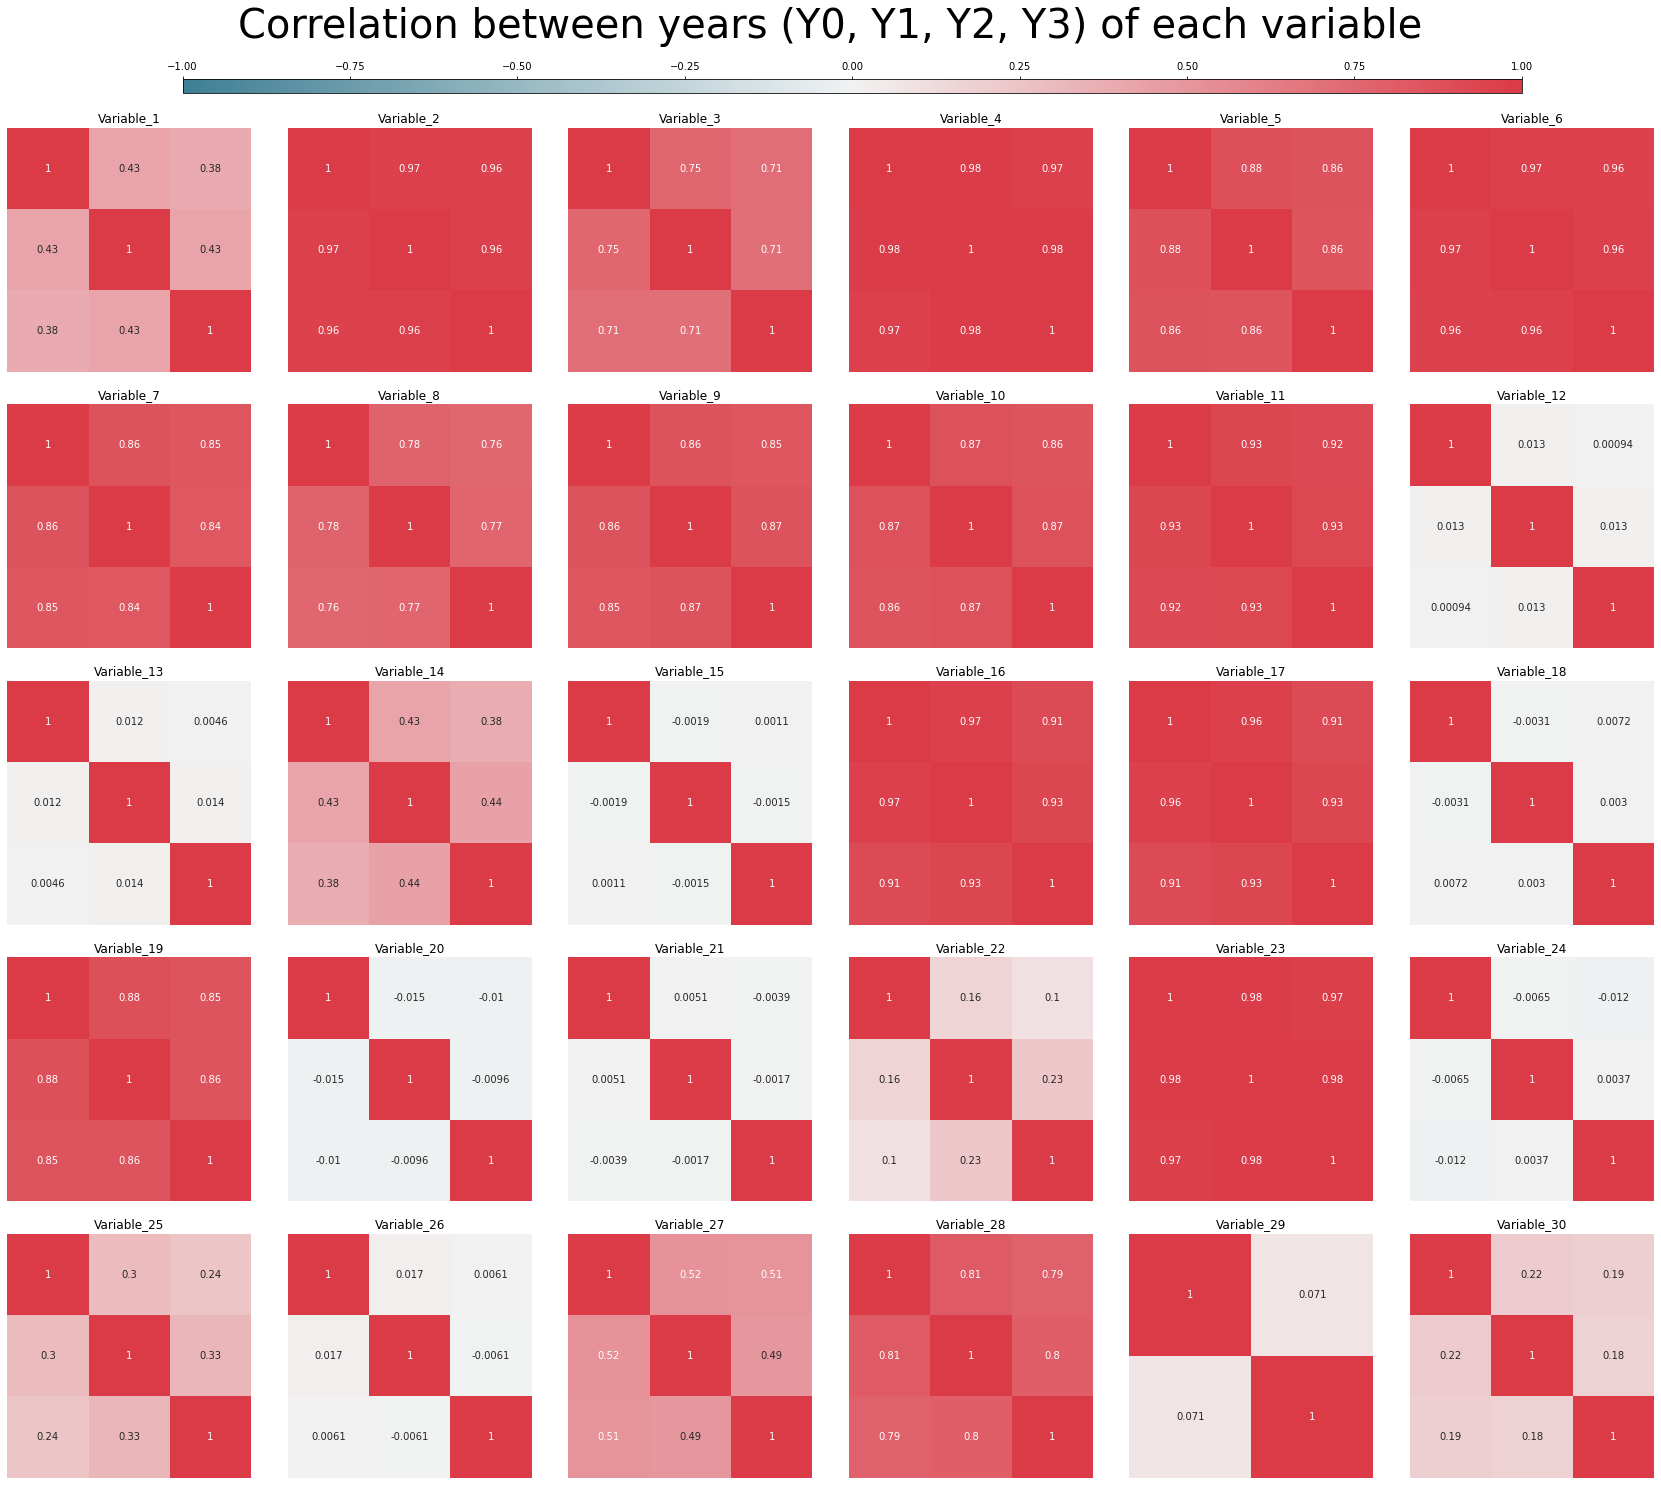

In [8]:
plot_within_var_corr(df_2)

/var/folders/cd/jmqvxpzd3fl3bkwgtg4gwnfc0000gn/T/ipykernel_59396/2628568303.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


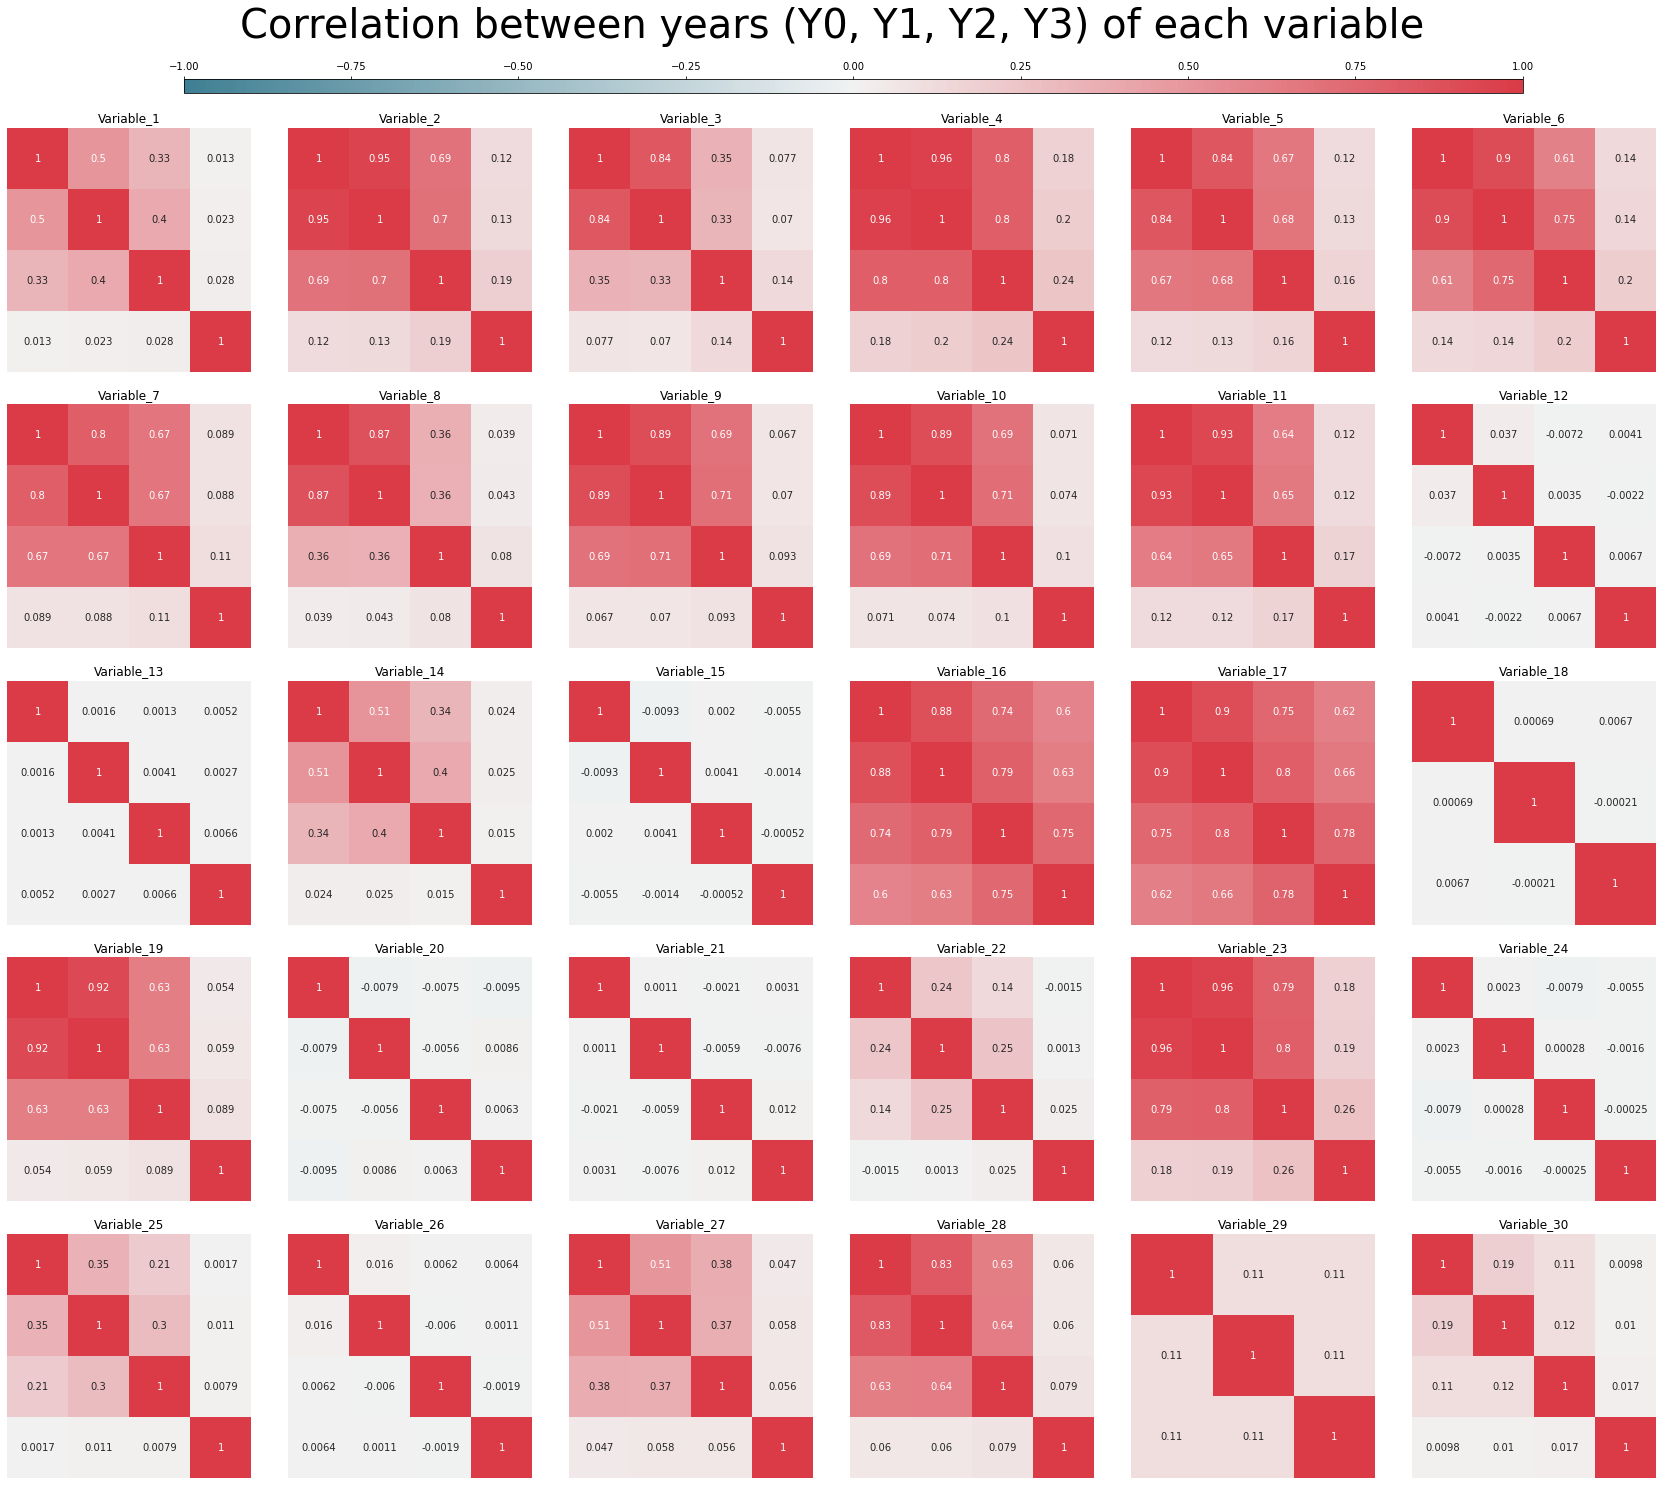

In [9]:
plot_within_var_corr(df_3)

/var/folders/cd/jmqvxpzd3fl3bkwgtg4gwnfc0000gn/T/ipykernel_59396/2628568303.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


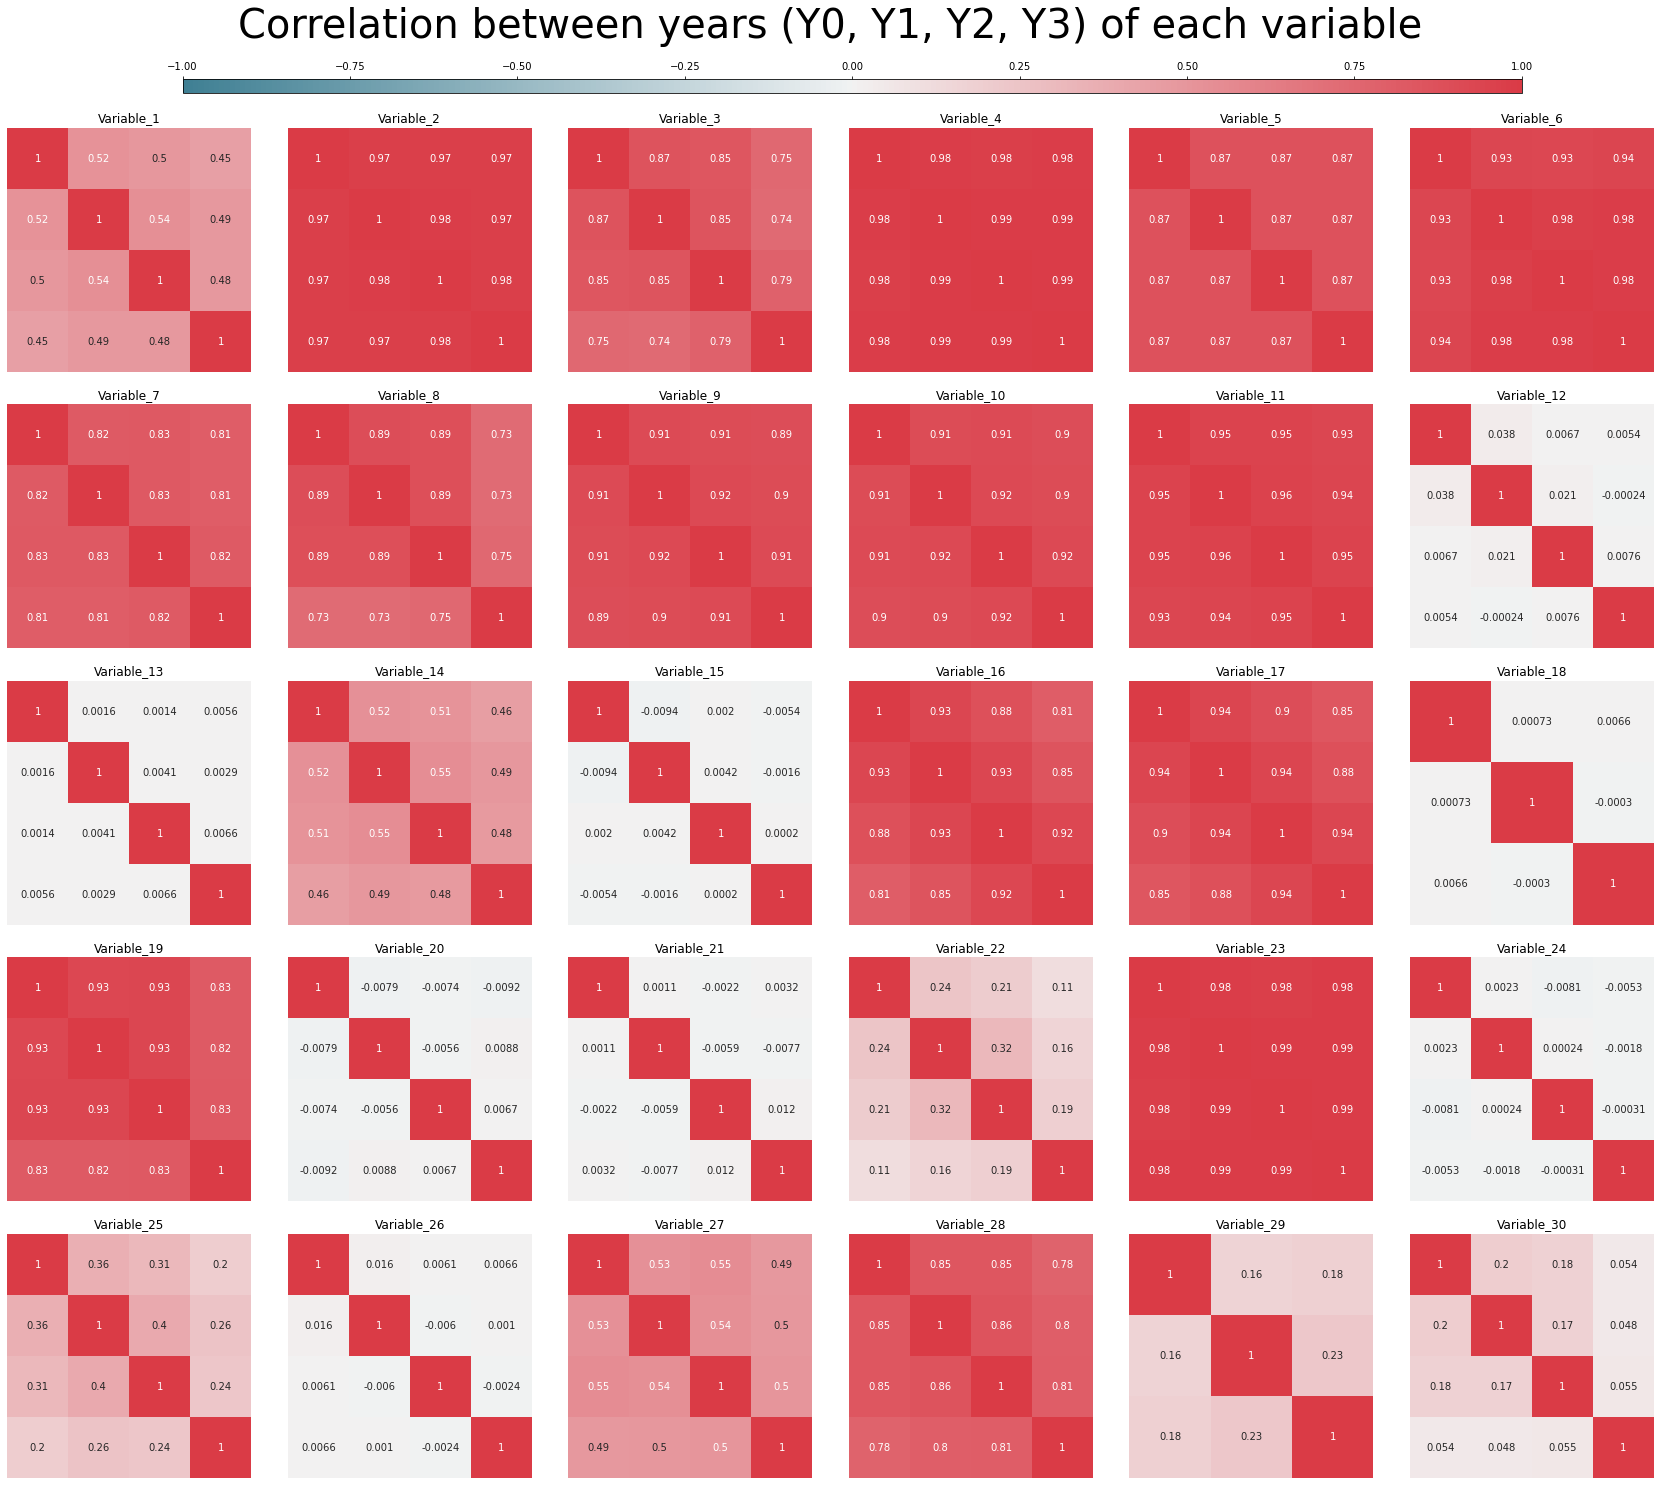

In [10]:
plot_within_var_corr(df_4)

In [11]:
# correlation of variables in each year (between all Y0's, Y1's, etc.) AFTER handling missing data
def plot_between_var_corr(df):
    max_year_index = max([int(col[-1]) for col in filter(lambda x: x.startswith("Variable_"), df.columns)])
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    fig, axs = plt.subplots(max_year_index+1, 1, figsize = (20,20*(max_year_index+1)))

    for i in range(max_year_index + 1):
        cols = list(filter(lambda x: x.endswith(f'_Y{i}'), df.columns))
        axs[i].set_title(f"Y{i}")
        sns.heatmap(data=df[cols].corr(), ax=axs[i], cmap=cmap, annot=True, vmin=-1, vmax=1,
                    square=True, cbar=False)

    fig.colorbar(axs[0].get_children()[0], ax=axs.ravel().tolist(), aspect=100, 
                 location="top", orientation="horizontal", anchor=(0.5, 1.57+0.05*(max_year_index+1)))
    fig.suptitle("Correlation between variables in each year", fontsize=40)
    fig.tight_layout()
    fig.subplots_adjust(top=0.918+0.01*(max_year_index+1))

    plt.show()

/var/folders/cd/jmqvxpzd3fl3bkwgtg4gwnfc0000gn/T/ipykernel_59396/2362719089.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


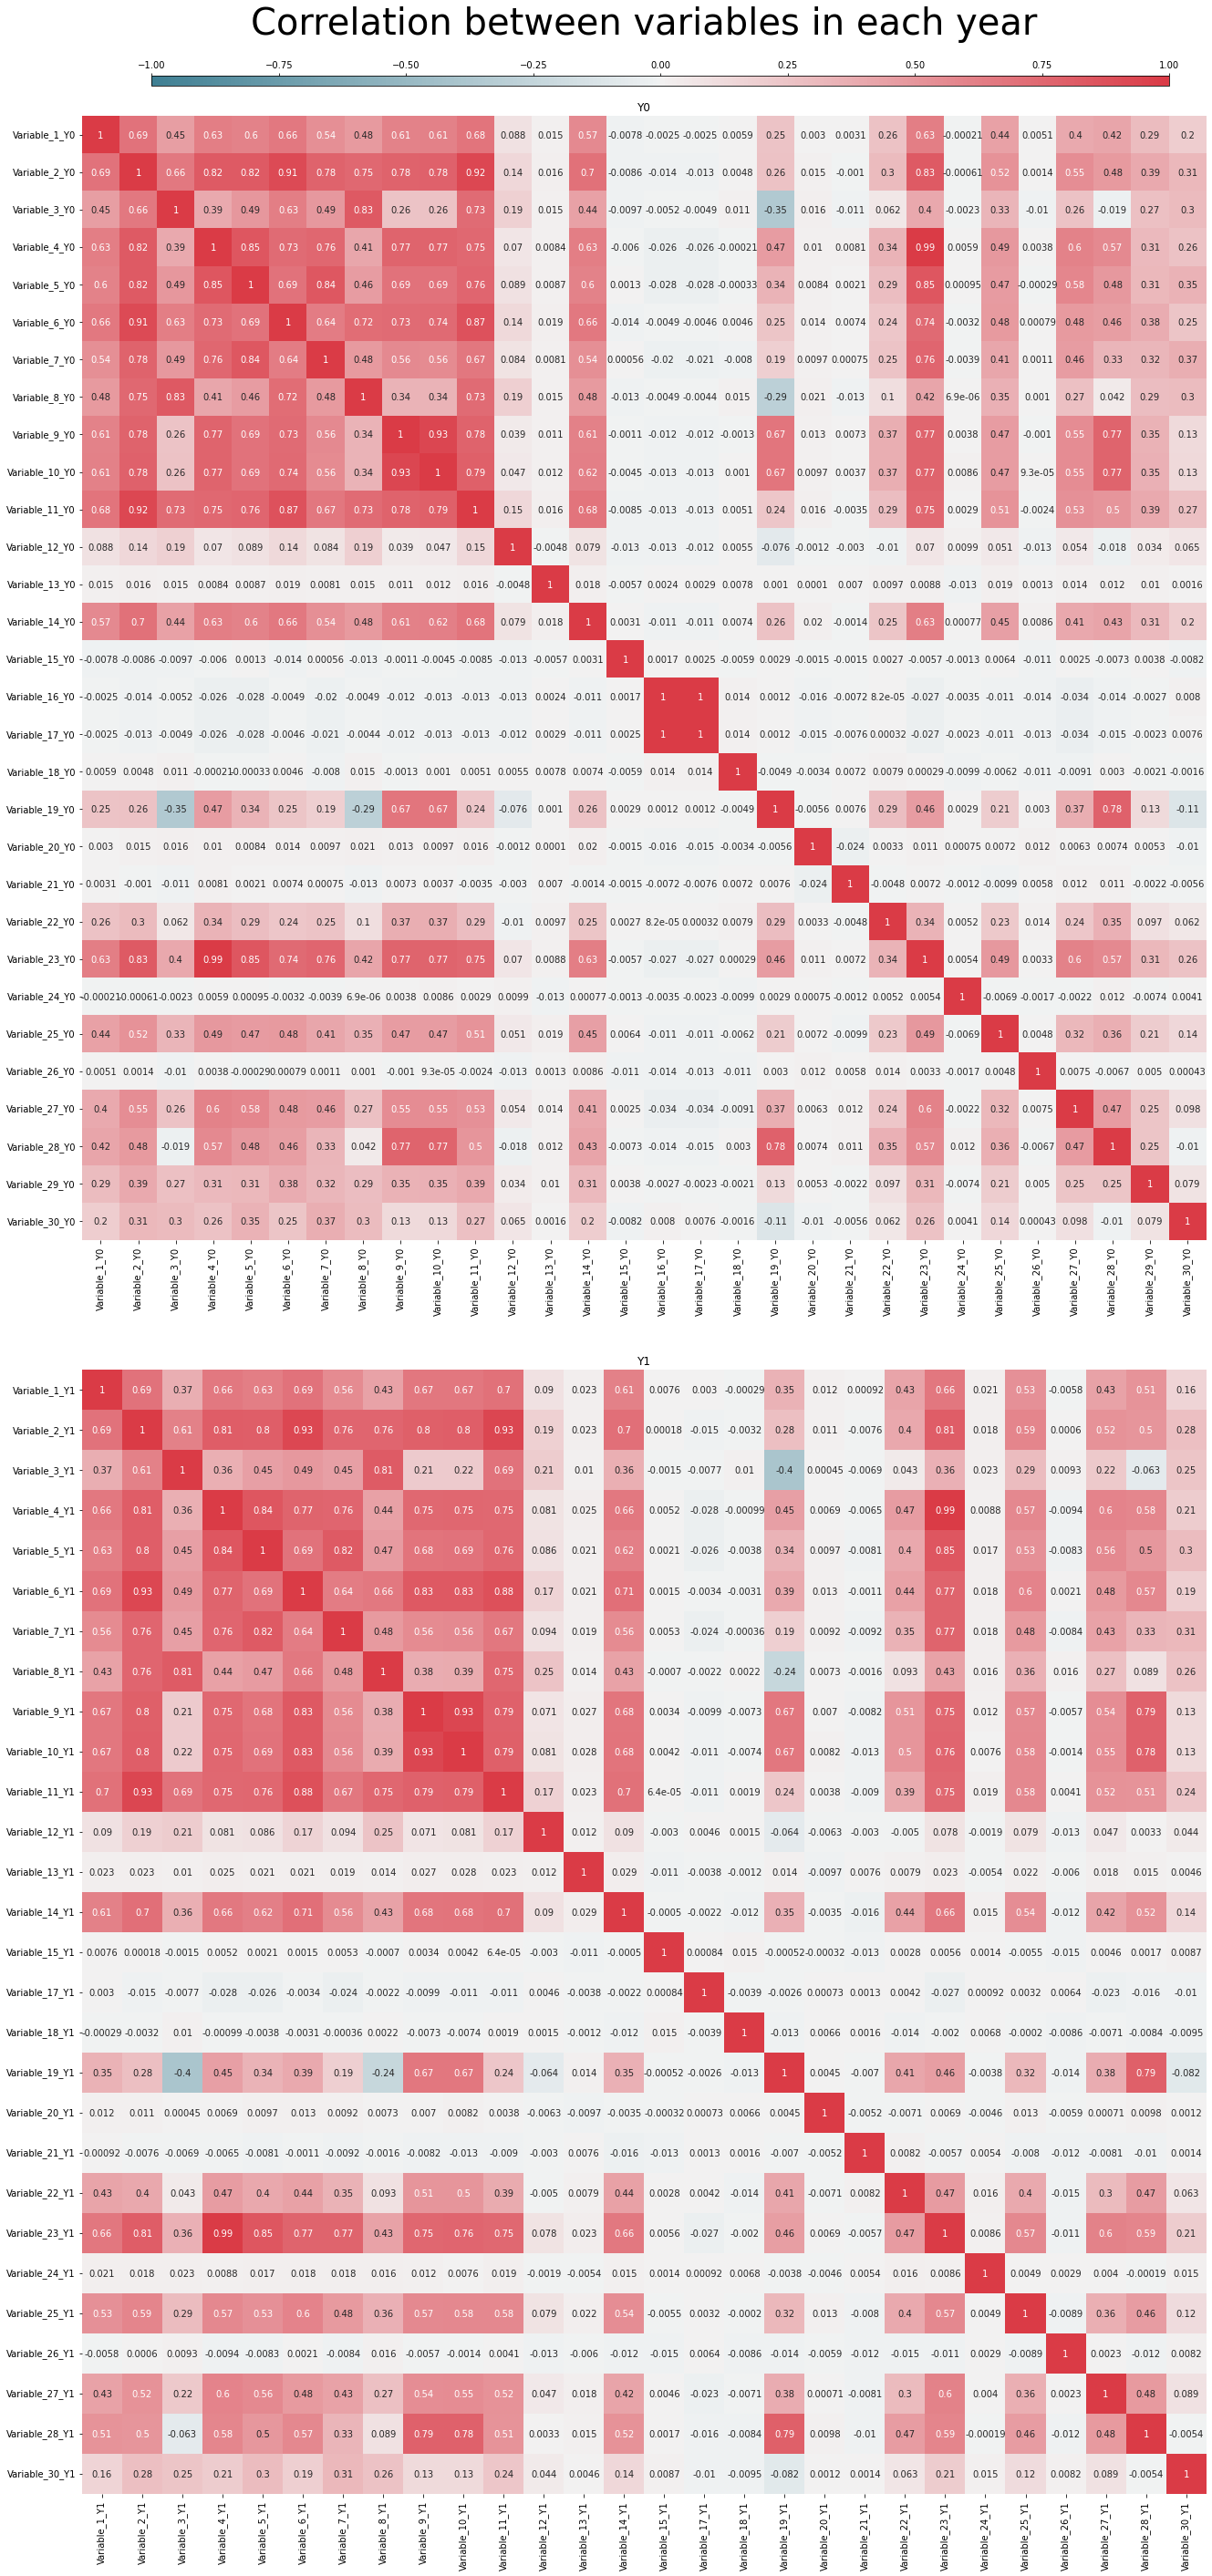

In [12]:
plot_between_var_corr(df_1)

/var/folders/cd/jmqvxpzd3fl3bkwgtg4gwnfc0000gn/T/ipykernel_59396/2362719089.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


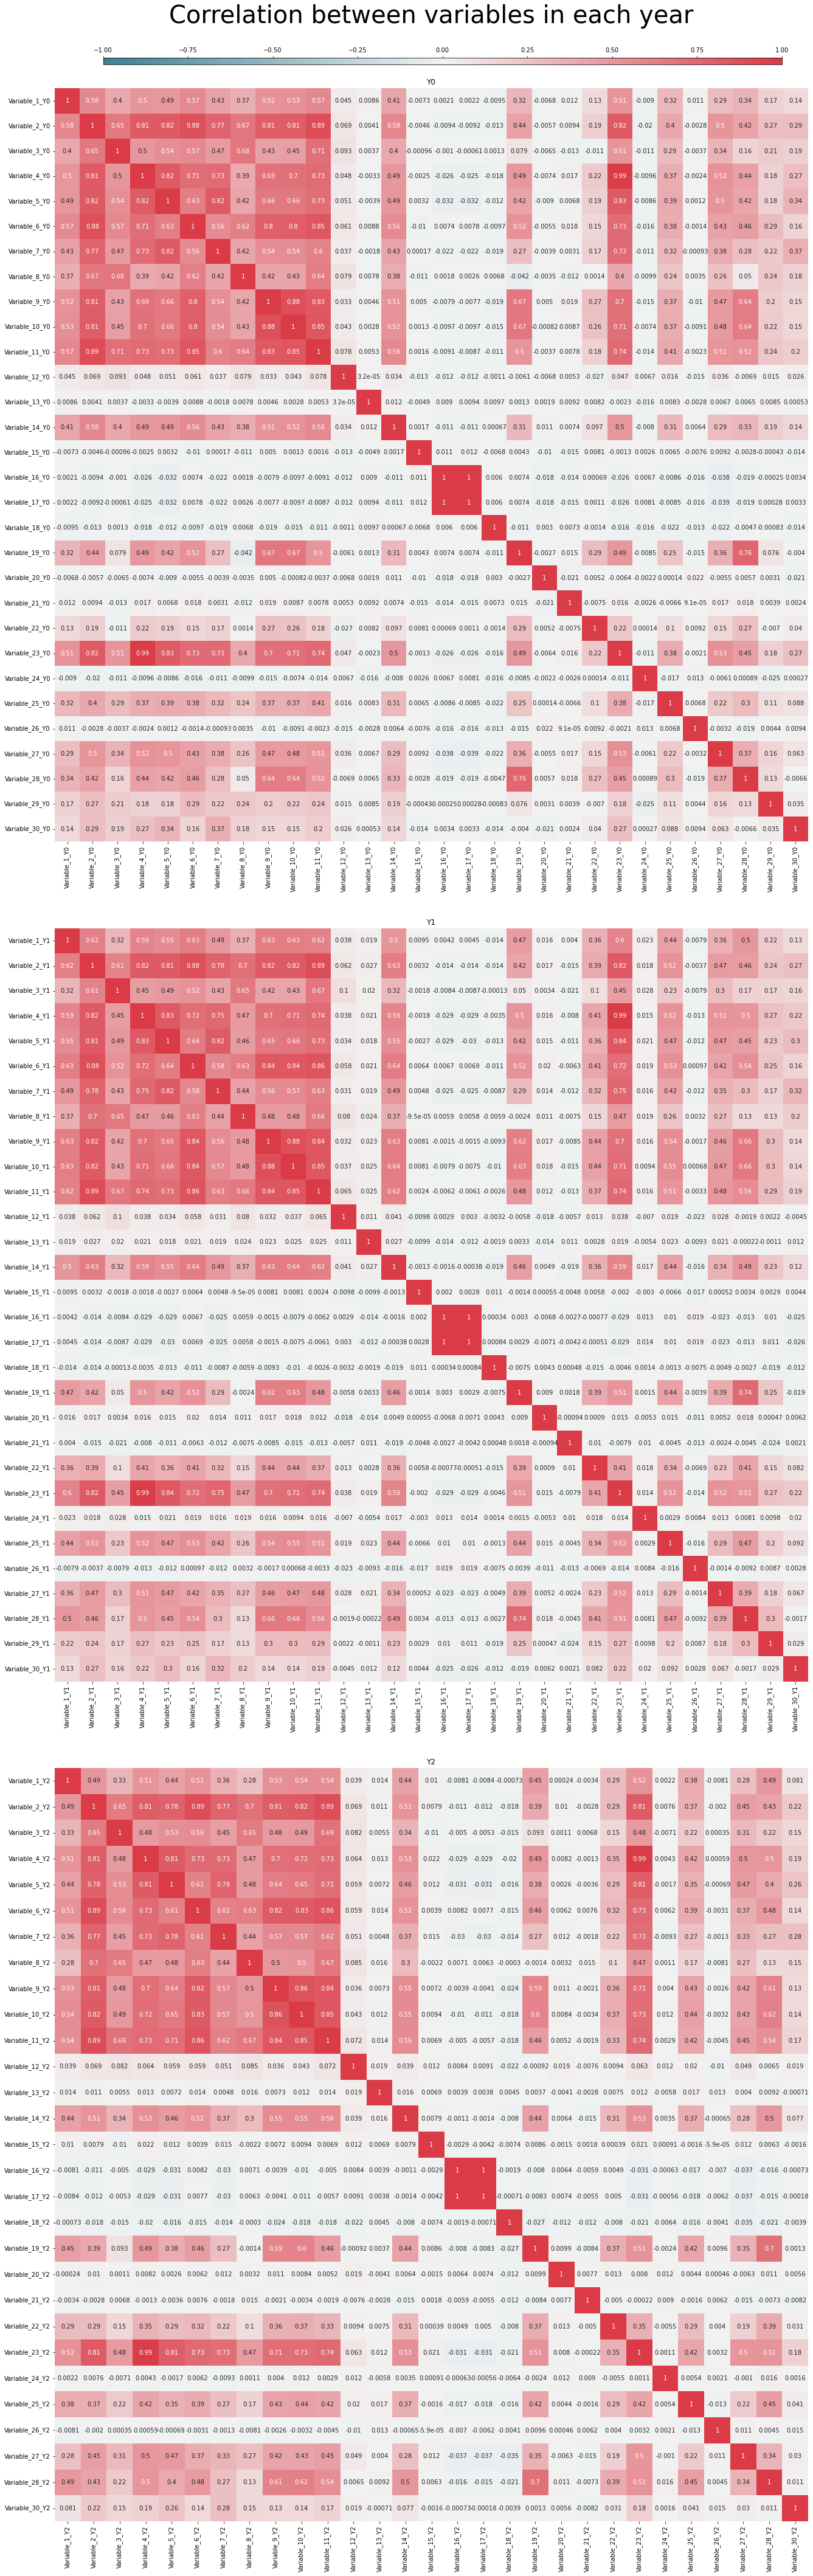

In [13]:
plot_between_var_corr(df_2)

/var/folders/cd/jmqvxpzd3fl3bkwgtg4gwnfc0000gn/T/ipykernel_59396/2362719089.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


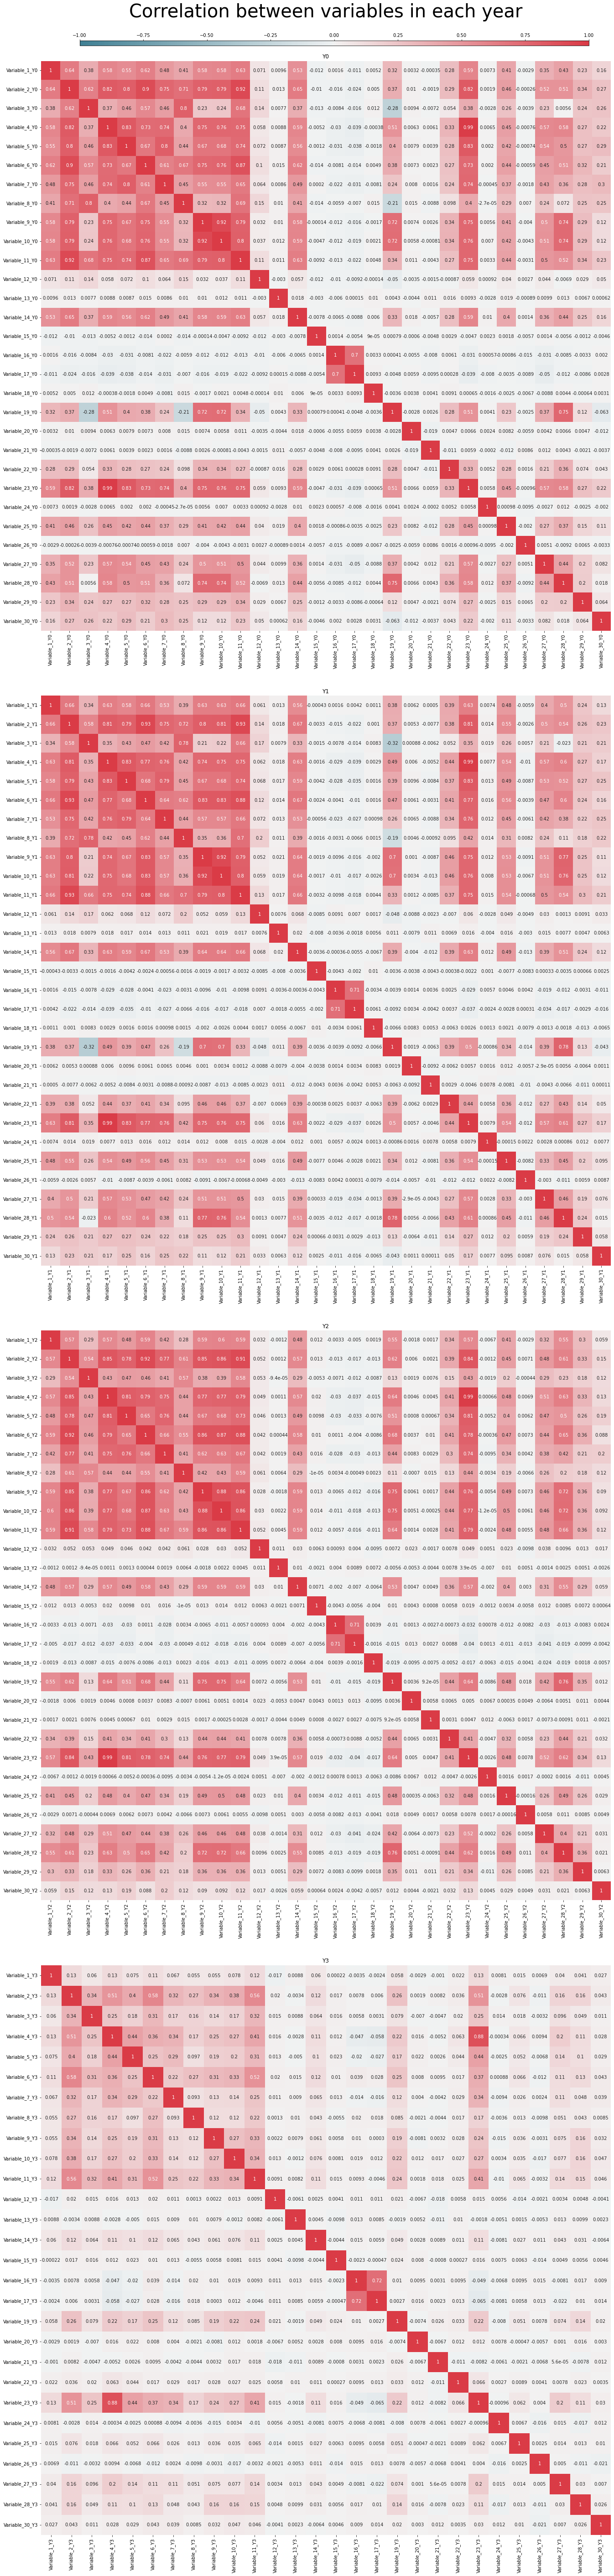

In [14]:
plot_between_var_corr(df_3)

/var/folders/cd/jmqvxpzd3fl3bkwgtg4gwnfc0000gn/T/ipykernel_59396/2362719089.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


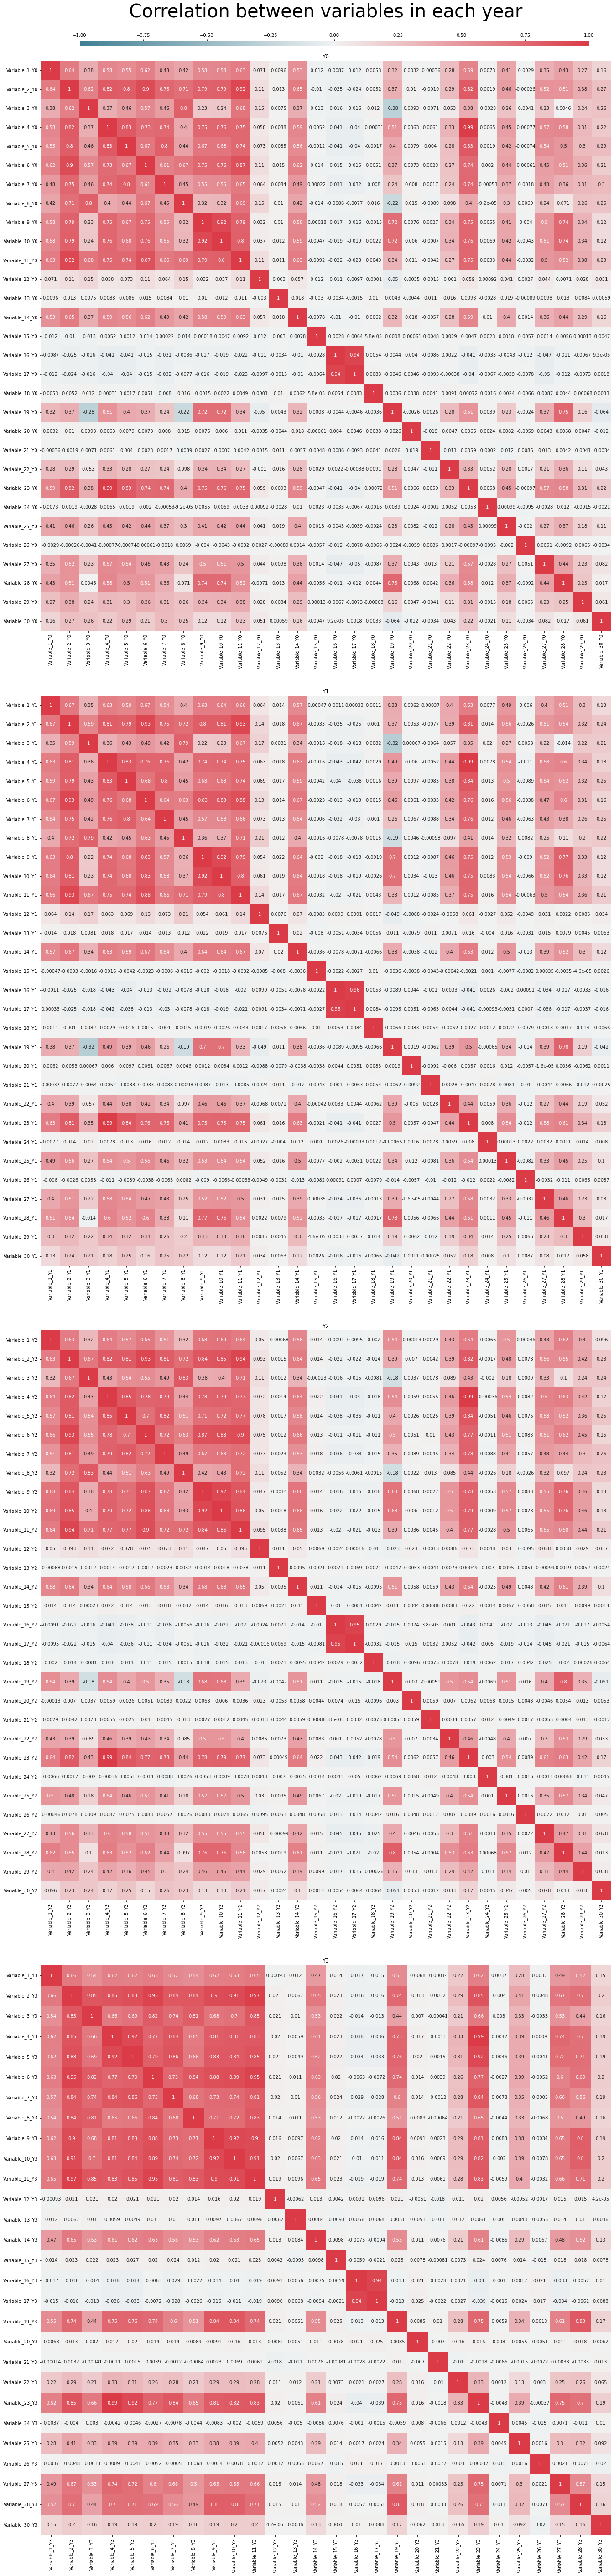

In [15]:
plot_between_var_corr(df_4)

In [16]:
# since in each of the 4 resulting data (by using different methods to handle missing data),
# variable 16 and 17 are both highly correlated within years and between each other,
# only the Y0 (current) value will be used (for low original missing rate) combining by averaging.
high_within_corr_cols = list(range(2,12)) + [16, 17, 19, 23, 28]
high_between_corr_cols = [4, 5, 6, 7, 8, 10, 11, 17, 23, 28]
def drop_high_corr_col(df):
    col_to_drop = list(filter(lambda x: x.startswith("Variable") and int(x.split("_")[1]) in high_within_corr_cols and not x.endswith("Y0"), df.columns))
    col_to_drop.extend(list(filter(lambda x: x.startswith("Variable") and int(x.split("_")[1]) in high_between_corr_cols and x not in col_to_drop, df.columns)))  
#     df["Variables_16-17"] = df.loc[:,["Variable_16_Y0", "Variable_17_Y0"]].mean()
    return df.drop(columns=col_to_drop)
df_1 = drop_high_corr_col(df_1)
df_2 = drop_high_corr_col(df_2)
df_3 = drop_high_corr_col(df_3)
df_4 = drop_high_corr_col(df_4)

## Feature selection based on the relationship to the outcome

In [17]:
# using anova correlation and kendall's rank coefficient to filter out low correlated variables
def check_corr_anova(df, features, target="risk_rating"):
    return np.array(df.columns[6:])[f_classif(df.loc[:,features], df[target])[1] <= 0.05].tolist()

def check_corr_kendall(df, features, target="risk_rating"):
    important_feature_kendall = []
    for col in features:
        tau, p_val = kendalltau(df.loc[:, col].to_numpy().reshape(-1,1), df[target])
        if p_val <= 0.05:
            important_feature_kendall.append(col)
    return important_feature_kendall

# for now, select features that are significant using EITHER tests (by using union on the results of both)
important_feature_1 = set(check_corr_kendall(df_1, df_1.columns[6:])).union(check_corr_anova(df_1, df_1.columns[6:]))
important_feature_2 = set(check_corr_kendall(df_2, df_2.columns[6:])).union(check_corr_anova(df_2, df_2.columns[6:]))
important_feature_3 = set(check_corr_kendall(df_3, df_3.columns[6:])).union(check_corr_anova(df_3, df_3.columns[6:]))
important_feature_4 = set(check_corr_kendall(df_4, df_4.columns[6:])).union(check_corr_anova(df_4, df_4.columns[6:]))

# remove the insignificant columns in each dataframe
df_1 = df_1.loc[:, df_1.columns[:6].tolist() + list(important_feature_1)]
df_2 = df_2.loc[:, df_2.columns[:6].tolist() + list(important_feature_2)]
df_3 = df_3.loc[:, df_3.columns[:6].tolist() + list(important_feature_3)]
df_4 = df_4.loc[:, df_4.columns[:6].tolist() + list(important_feature_4)]

In [18]:
# save to files
df_1.to_csv("../data/processed/df_1.csv")
df_2.to_csv("../data/processed/df_2.csv")
df_3.to_csv("../data/processed/df_3.csv")
df_4.to_csv("../data/processed/df_4.csv")

In [19]:
df_1

Country_Code  BR Code  Period  Client  risk_rating  Self_exclude_flag  \
0                 0        0  2017Q2       0            7                  1   
1                 0        0  2016Q1       0            7                  1   
2                 0        0  2015Q4       0            7                  1   
3                 0        0  2015Q2       0            7                  1   
6                 0        2  2017Q3       3            4                  1   
...             ...      ...     ...     ...          ...                ...   
28214             0        8  2017Q3   14026           11                  0   
28215             0        8  2017Q1   14026           11                  0   
28219             1        5  2019Q3   14029            9                  0   
28220             0       18  2019Q2   14030            7                  1   
28221             0       18  2017Q2   14030            7                  1   

       Variable_13_Y1  Variable_27_Y0  Variable_9_Y0  Variable_3_Y0  \
0          579,310.18      601,705.18     603,082.27     592,374.30   
1          628,400.28      597,987.51     585,387.26     595,587.67   
2          610,811.10      616,662.11     598,712.79     576,546.05   
3          619,342.92      614,192.37     620,889.12     575,206.33   
6          591,500.50      571,532.38     610,227.62     598,898.00   
...               ...             ...            ...            ...   
28214      614,828.56      580,239.73     607,477.09     610,785.23   
28215      578,798.95      625,594.07     624,998.02     627,049.16   
28219      603,044.86      582,876.85     597,395.52     595,628.78   
28220      569,870.64      590,002.47     628,436.46     579,714.16   
28221      578,699.58      570,508.53     627,912.13     596,397.88   

       Variable_12_Y0  Variable_1_Y0  Variable_25_Y0  Variable_19_Y0  \
0          605,911.70     581,103.46      615,628.99      618,894.66   
1          623,671.13     608,189.37      583,923.46      630,064.13   
2          581,512.02     626,775.44      591,576.17      600,410.73   
3          626,126.75     613,152.45      592,747.47      607,121.68   
6          612,922.33     586,578.55      576,444.54      594,405.01   
...               ...            ...             ...             ...   
28214      581,045.66     610,596.85      587,950.01      611,369.59   
28215      599,137.55     579,632.97      602,442.13      578,547.34   
28219      606,097.27     613,443.86      599,898.21      574,225.67   
28220      598,436.15     617,117.24      610,358.54      588,235.73   
28221      622,211.47     598,289.62      576,478.94      570,375.66   

       Variable_30_Y1  Variable_22_Y0  Variable_14_Y1  Variable_14_Y0  \
0          623,659.10      574,223.73      619,734.39      592,690.48   
1          592,011.41      577,540.66      594,133.04      627,406.92   
2          572,241.03      572,907.54      581,073.91      578,597.67   
3          578,761.71      627,385.20      605,762.14      569,934.38   
6          615,681.52      618,654.08      611,702.96      615,139.19   
...               ...             ...             ...             ...   
28214      569,396.22      575,782.33      627,113.40      596,559.30   
28215      625,644.39      622,748.82      575,835.58      605,741.58   
28219      611,674.92      586,873.35      585,522.84      617,025.75   
28220      610,247.36      604,748.98      614,011.68      611,514.60   
28221      569,991.46      588,882.86      594,475.77      582,233.97   

       Variable_16_Y0  Variable_21_Y0  Variable_30_Y0  Variable_29_Y0  \
0          626,840.47      569,635.50      588,163.83      577,170.31   
1          606,359.13      608,572.69      591,055.82      581,951.02   
2          627,671.88      587,802.91      626,221.09      590,490.36   
3          580,507.22      614,676.50      619,098.66      580,633.87   
6          622,216.43      617,879.32      587,953.75      602,415.09   
...          